In [69]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
import time

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib as mpl
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 100

# SIR model
$$\frac{S}{dt} = -\beta IS \\
\frac{dI}{dt} = \beta IS - \gamma I \\
\frac{dR}{dt} = \gamma I.$$

- train on [0,50], prediction on [0,60]

In [44]:
# Parameters

initial_S = 990  # Initial number of susceptible individuals
initial_I = 20  # Initial number of infectious individuals
initial_R = 0 # Initial number of recovered individuals
N = initial_S + initial_I + initial_R # Total population size

beta = 0.001  # Rate of infection
gamma = 0.1  # Rate of recovery

In [45]:
# Generate synthetic data
torch.manual_seed(0)
x_train = torch.rand(1000) * 50  # Range [0, 50] with 1000 points
x_train, _ = torch.sort(x_train)

In [46]:
# RK4 
# Function defining the SIS model equations
def SIR_model(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * I * S
    dIdt = beta * I * S - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

t_span = (0, 50)  # Time span for integration
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points for evaluation

# Initial conditions
y0 = [initial_S, initial_I, initial_R]

# Solve the ODEs
sol = solve_ivp(SIR_model, t_span, y0, args=(beta, gamma), dense_output=True)

y_eval = sol.sol(t_eval)

In [47]:
y1_true = torch.from_numpy(y_eval[0])
y2_true = torch.from_numpy(y_eval[1])
y3_true = torch.from_numpy(y_eval[2])

In [48]:
# Define the ODE functions
def f1(S, I):
    return -beta*I*S
def f2(S, I):
    return beta*I*S - gamma*I
def f3(S, I):
    return gamma*I

In [49]:
# Calculate the true local truncation error
def true_truncation_error(x_i, x_j, y1_i, y1_j, y2_i, y2_j, y3_i, y3_j, eq):
    if eq == 'f1':
        return (1/(x_j - x_i) ** 2)*(y1_j - y1_i - (x_j - x_i) * f1(y1_i, y2_i))
    elif eq == 'f2':
        return (1/(x_j - x_i) ** 2)*(y2_j - y2_i - (x_j - x_i) * f2(y1_i, y2_i))
    elif eq == 'f3':
        return (1/(x_j - x_i) ** 2)*(y3_j - y3_i - (x_j - x_i) * f3(y1_i, y2_i))

In [50]:
# Generate training samples for the neural network
N = len(x_train)
samples_y1 = []
samples_y2 = []
samples_y3 = []
for i in range(N):
    for j in range(i + 1, N):
        x_i, x_j = x_train[i], x_train[j]
        y1_i, y1_j = y1_true[i], y1_true[j]
        y2_i, y2_j = y2_true[i], y2_true[j]
        y3_i, y3_j = y3_true[i], y3_true[j]
        samples_y1.append((x_i, x_j, y1_i, true_truncation_error(x_i, x_j, y1_i, y1_j, y2_i, y2_j, y3_i, y3_j, 'f1')))
        samples_y2.append((x_i, x_j, y2_i, true_truncation_error(x_i, x_j, y1_i, y1_j, y2_i, y2_j, y3_i, y3_j, 'f2')))
        samples_y3.append((x_i, x_j, y3_i, true_truncation_error(x_i, x_j, y1_i, y1_j, y2_i, y2_j, y3_i, y3_j, 'f3')))

# Shuffle the samples
np.random.shuffle(samples_y1)
np.random.shuffle(samples_y2)
np.random.shuffle(samples_y3)

In [51]:
# Prepare the data for training
X1 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i, _ in samples_y1], dtype=torch.float32) # x_i, x_j, y_i
X2 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i, _ in samples_y2], dtype=torch.float32) # x_i, x_j, y_i
X3 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i, _ in samples_y3], dtype=torch.float32) # x_i, x_j, y_i

y1 = torch.tensor([R for _, _, _, R in samples_y1], dtype=torch.float32) # truncation error for this x_i, x_j, y_i
y2 = torch.tensor([R for _, _, _, R in samples_y2], dtype=torch.float32) # truncation error for this x_i, x_j, y_i
y3 = torch.tensor([R for _, _, _, R in samples_y3], dtype=torch.float32) # truncation error for this x_i, x_j, y_i

In [52]:
# Define the neural network model
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(3, 80)
        self.fc2 = nn.Linear(80, 80)
        self.fc3 = nn.Linear(80, 80)
        self.fc4 = nn.Linear(80, 80)
        self.fc5 = nn.Linear(80, 80)
        self.fc6 = nn.Linear(80, 80)
        self.fc7 = nn.Linear(80, 80)
        self.fc8 = nn.Linear(80, 80)
        self.fc9 = nn.Linear(80, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = self.fc9(x)
        return x

In [53]:
# Define the custom loss function
def custom_loss(y_true, y_pred):
    error = torch.abs(y_pred - y_true)
    loss = 2 / (N * (N - 1)) * torch.sum(error)
    return loss

In [54]:
# Generate synthetic data - data for testing
torch.manual_seed(0)
h = 0.01
x_test = torch.arange(0, 60, h)  # Range [0, 15] 
N = len(x_test)

In [55]:
x_span = (0, 60)  # Time span for integration
x_eval = x_test.numpy()  # Time points for evaluation

# Initial conditions
y0 = [990, 20, 0]

# Solve the ODEs
sol = solve_ivp(SIR_model, x_span, y0, args=(beta, gamma), dense_output=True)

y_eval = sol.sol(x_eval)

In [56]:
y1_test_true = torch.from_numpy(y_eval[0])
y2_test_true = torch.from_numpy(y_eval[1])
y3_test_true = torch.from_numpy(y_eval[2])

In [57]:
# Compute the Euler's method solution

# Function to compute the derivatives 
def SIR(S, I, R):
    dSdt = -beta * I * S
    dIdt = beta * I * S - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial populations
y1_0 = 990  # Initial prey population
y2_0 = 20   # Initial predator population
y3_0 = 0

# Time parameters
t0 = 0    # Initial time
T = 60   # Total time
dt = 0.01  # Time step size - h

# Number of time steps
num_steps = int(T / dt)

# Arrays to store population values
y1_values = np.zeros(num_steps)
y2_values = np.zeros(num_steps)
y3_values = np.zeros(num_steps)
time_values = np.linspace(t0, T, num_steps)

# Set initial values
y1_values[0] = y1_0
y2_values[0] = y2_0
y3_values[0] = y3_0

# Perform Euler's method
for i in range(num_steps-1):
    dy1_dx, dy2_dx, dy3_dx = SIR(y1_values[i], y2_values[i],  y3_values[i])
    y1_values[i+1] = y1_values[i] + dt * dy1_dx
    y2_values[i+1] = y2_values[i] + dt * dy2_dx
    y3_values[i+1] = y3_values[i] + dt * dy3_dx

y1_euler = y1_values
y2_euler = y2_values
y3_euler = y3_values

In [58]:
x_test_for_NN1 = []
x_test_for_NN2 = []
x_test_for_NN3 = []
for i in range(len(x_test)-1):
    x_test_for_NN1.append((x_test[i], x_test[i+1], y1_test_true[i]))  # x_i, x_j, y_i
    x_test_for_NN2.append((x_test[i], x_test[i+1], y2_test_true[i]))  # x_i, x_j, y_i
    x_test_for_NN3.append((x_test[i], x_test[i+1], y3_test_true[i]))  # x_i, x_j, y_i

In [59]:
x_test_for_NN1 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN1], dtype=torch.float32)
x_test_for_NN2 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN2], dtype=torch.float32)
x_test_for_NN3 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN3], dtype=torch.float32)

In [60]:
# run the model several times to check robustness of the method
number_of_iterations = 10
y1_finals = []
y2_finals = []
y3_finals = []
for i in range(number_of_iterations):
    print(i)
    # Create the neural network model
    nn_model_y1 = NNModel()
    nn_model_y2 = NNModel()
    nn_model_y3 = NNModel()

    # Define the optimizer
    optimizer_y1 = optim.Adam(nn_model_y1.parameters(), lr=.005)
    optimizer_y2 = optim.Adam(nn_model_y2.parameters(), lr=.005)
    optimizer_y3 = optim.Adam(nn_model_y3.parameters(), lr=.005)

    # Train the neural network
    num_epochs = 50
    #losses = []
    for epoch in range(num_epochs):
        optimizer_y1.zero_grad()
        optimizer_y2.zero_grad()
        optimizer_y3.zero_grad()

        outputs_y1 = nn_model_y1(X1).flatten()
        outputs_y2 = nn_model_y2(X2).flatten()
        outputs_y3 = nn_model_y3(X3).flatten()

        loss = custom_loss(outputs_y1, y1) + custom_loss(outputs_y2, y2) + custom_loss(outputs_y3, y3)
        loss.backward()

        optimizer_y1.step()
        optimizer_y2.step()
        optimizer_y3.step()
        
    h = 0.01
    # Predict the truncation error using the neural network
    y1_pred = nn_model_y1(x_test_for_NN1)
    y2_pred = nn_model_y2(x_test_for_NN2)
    y3_pred = nn_model_y3(x_test_for_NN3)

    y1_pred = y1_pred.detach().numpy().flatten()
    y2_pred = y2_pred.detach().numpy().flatten()
    y3_pred = y3_pred.detach().numpy().flatten()

    y1_pred = np.insert(y1_pred,0,0)
    y2_pred = np.insert(y2_pred,0,0)
    y3_pred = np.insert(y3_pred,0,0)

    # Compute the final solution by adding Euler's method output and the predicted truncation error
    y1_final = y1_euler + h*y1_pred
    y2_final = y2_euler + h*y2_pred
    y3_final = y3_euler + h*y3_pred

    y1_finals.append(y1_final)
    y2_finals.append(y2_final)
    y3_finals.append(y3_final)

0
1
2
3
4
5
6
7
8
9


In [61]:
# std
std_y1_finals = np.std(y1_finals, axis=0)
std_y2_finals = np.std(y2_finals, axis=0)
std_y3_finals = np.std(y3_finals, axis=0)

df_std_y1y2y3 = pd.DataFrame({'S': std_y1_finals, 'I': std_y2_finals, 'R': std_y3_finals})

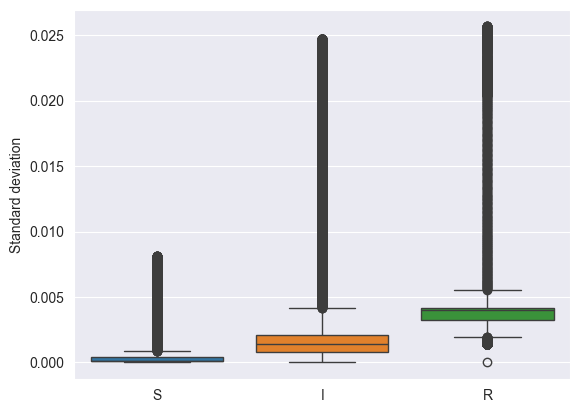

In [62]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df_std_y1y2y3)
ax.set(ylabel='Standard deviation')
#fig.savefig('graphs/DEM_std_SIR.pdf')

In [63]:
y1_final = np.mean(y1_finals, axis=0)
y2_final = np.mean(y2_finals, axis=0)
y3_final = np.mean(y3_finals, axis=0)

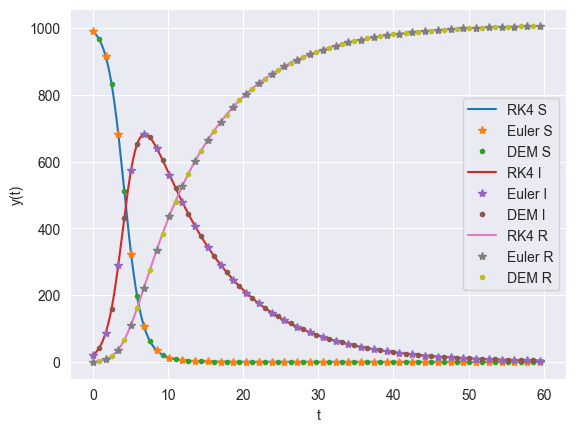

In [64]:
# Plot the solutions
fig, ax = plt.subplots()
plt.plot(x_test.numpy(), y1_test_true.numpy(), label='RK4 S')
plt.plot(x_test.numpy()[::170], y1_euler[::170], '*', label="Euler S")
plt.plot(x_test.numpy()[80::170], y1_final[80::170], '.', label='DEM S')
plt.plot(x_test.numpy(), y2_test_true.numpy(), label='RK4 I')
plt.plot(x_test.numpy()[::170], y2_euler[::170], '*', label="Euler I")
plt.plot(x_test.numpy()[80::170], y2_final[80::170], '.', label='DEM I')
plt.plot(x_test.numpy(), y3_test_true.numpy(), label='RK4 R')
plt.plot(x_test.numpy()[::170], y3_euler[::170], '*', label="Euler R")
plt.plot(x_test.numpy()[80::170], y3_final[80::170], '.', label='DEM R')
#plt.title("Comparison of solutions of SIR model")
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.grid(True)
plt.show()
#fig.savefig('graphs/DEM_solutions_SIR.pdf')

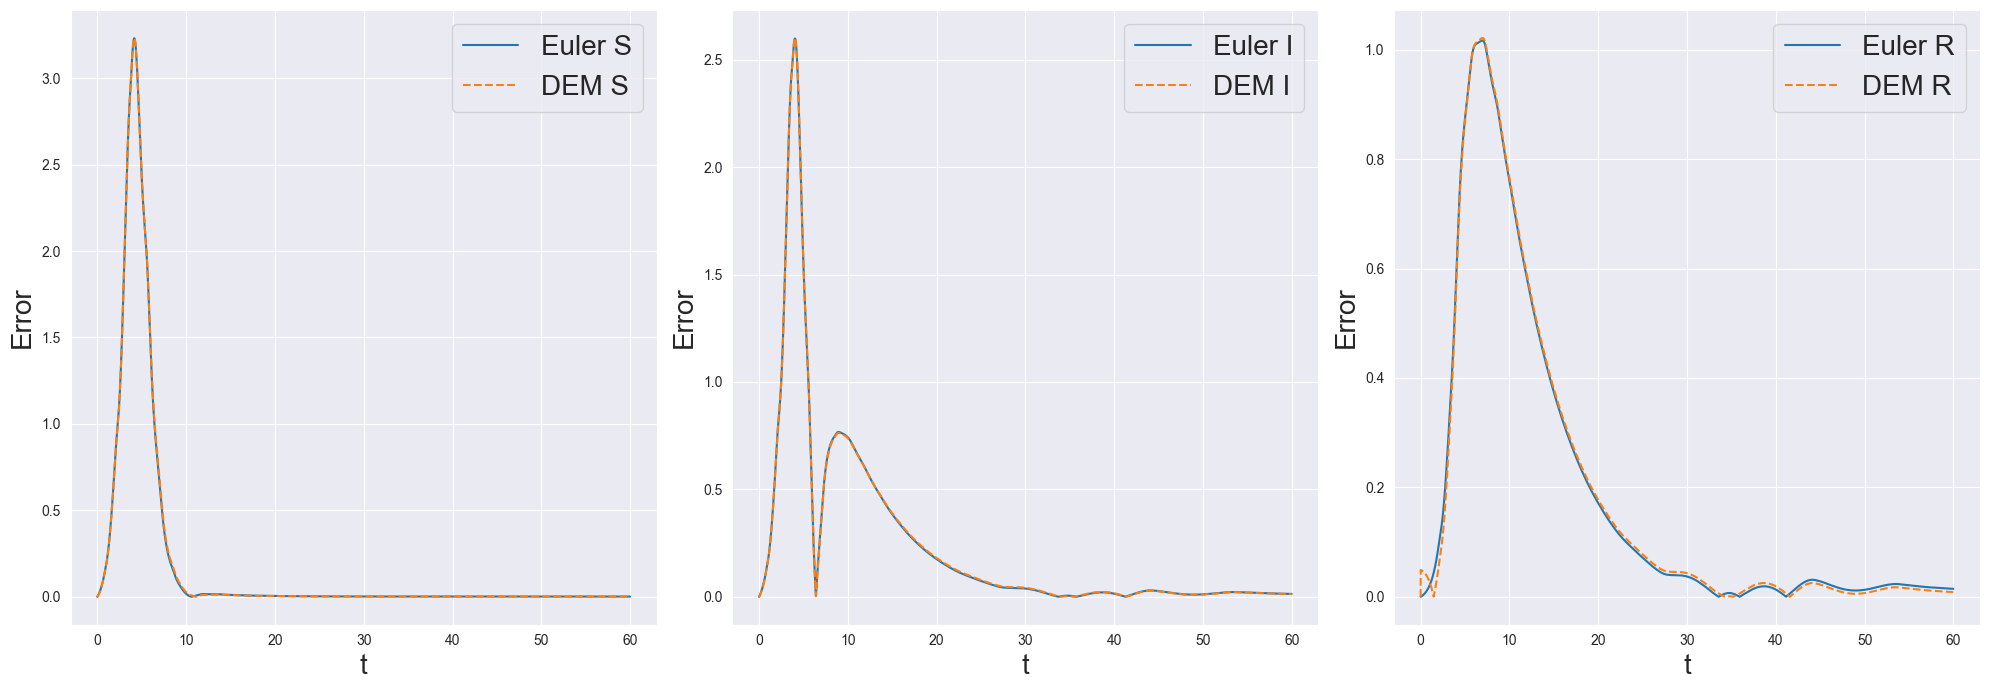

In [65]:
# Plot the errors
# h = 0.01
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

axs[0].plot(x_test.numpy(), abs(y1_euler-y1_test_true.numpy()), label="Euler S")
axs[0].plot(x_test.numpy(), abs(y1_final-y1_test_true.numpy()), label='DEM S', linestyle='--')
#axs[0].set_title('Comparison of errors of solutions of S from SIR model', fontsize=17)
axs[0].set_xlabel('t', fontsize=20)
axs[0].set_ylabel('Error', fontsize=20)
axs[0].legend(fontsize=20)

axs[1].plot(x_test.numpy(), abs(y2_euler-y2_test_true.numpy()), label="Euler I")
axs[1].plot(x_test.numpy(), abs(y2_final-y2_test_true.numpy()), label='DEM I', linestyle='--')
#axs[1].set_title('Comparison of errors of solutions of I from SIR model', fontsize=17)
axs[1].set_xlabel('t', fontsize=20)
axs[1].set_ylabel('Error', fontsize=20)
axs[1].legend(fontsize=20)

axs[2].plot(x_test.numpy(), abs(y3_euler-y3_test_true.numpy()), label="Euler R")
axs[2].plot(x_test.numpy(), abs(y3_final-y3_test_true.numpy()), label='DEM R', linestyle='--')
#axs[2].set_title('Comparison of errors of solutions of R from SIR model', fontsize=17)
axs[2].set_xlabel('t', fontsize=20)
axs[2].set_ylabel('Error', fontsize=20)
axs[2].legend(fontsize=20)

fig.tight_layout()
#fig.savefig('graphs/DEM_errors_SIR.pdf')

In [66]:
# MAE
print("MAE for Euler comparing to RK4 solution for S:", round(mae(y1_euler, y1_test_true.numpy()),3))
print("MAE for Euler comparing to RK4 solution for I:", round(mae(y2_euler, y2_test_true.numpy()),3))
print("MAE for Euler comparing to RK4 solution for R:", round(mae(y3_euler, y3_test_true.numpy()),3))

print("MAE for DEM comparing to RK4 solution for S", round(mae(y1_final, y1_test_true.numpy()),3))
print("MAE for DEM comparing to RK4 solution for I", round(mae(y2_final, y2_test_true.numpy()),3))
print("MAE for DEM comparing to RK4 solution for R", round(mae(y3_final, y3_test_true.numpy()),3))


MAE for Euler comparing to RK4 solution for S: 0.185
MAE for Euler comparing to RK4 solution for I: 0.245
MAE for Euler comparing to RK4 solution for R: 0.19
MAE for DEM comparing to RK4 solution for S 0.186
MAE for DEM comparing to RK4 solution for I 0.246
MAE for DEM comparing to RK4 solution for R 0.19


In [72]:
# comparison of the errors for different h - here no averaging over 10 trained models

h_list = [0.001, 0.01, 0.1, 1, 2, 3]
errors_euler_y1 = []
errors_DEM_y1 = []
errors_euler_y2 = []
errors_DEM_y2 = []
errors_euler_y3 = []
errors_DEM_y3 = []
times_euler = []
times_DEM = []
for h in h_list:
    x_test = torch.arange(0, 60, h)  # Range [0, 60] 
    N = len(x_test)
    
    # RK4 
    # Function defining the SIS model equations
    def SIR_model(t, y, beta, gamma):
        S, I, R = y
        dSdt = -beta * I * S
        dIdt = beta * I * S - gamma * I
        dRdt = gamma * I
        return [dSdt, dIdt, dRdt]
    
    x_span = (0, 60)  # Time span for integration
    x_eval = x_test.numpy()  # Time points for evaluation

    # Initial conditions
    y0 = [990, 20, 0]

    # Solve the ODEs
    sol = solve_ivp(SIR_model, x_span, y0, args=(beta, gamma), dense_output=True)

    y_eval = sol.sol(x_eval)
    
    # Compute the Euler's method solution
    y1_test_true = torch.from_numpy(y_eval[0])
    y2_test_true = torch.from_numpy(y_eval[1])
    y3_test_true = torch.from_numpy(y_eval[2])

    # Compute the Euler's method solution
    # Function to compute the derivatives 
    def SIR(S, I, R):
        dSdt = -beta * I * S
        dIdt = beta * I * S - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial populations
    y1_0 = 990  # Initial prey population
    y2_0 = 20   # Initial predator population
    y3_0 = 0

    # Time parameters
    t0 = 0    # Initial time
    T = 60   # Total time
    dt = h  # Time step size - h

    # Number of time steps
    num_steps = int(T / dt)
    time_values = np.linspace(t0, T, num_steps)
    
    start_time_euler = time.time()

    # Arrays to store population values
    y1_values = np.zeros(num_steps)
    y2_values = np.zeros(num_steps)
    y3_values = np.zeros(num_steps)

    # Set initial values
    y1_values[0] = y1_0
    y2_values[0] = y2_0
    y3_values[0] = y3_0

    # Perform Euler's method
    for i in range(num_steps-1):
        dy1_dx, dy2_dx, dy3_dx = SIR(y1_values[i], y2_values[i],  y3_values[i])
        dt = x_test[i+1] - x_test[i]
        dt = dt.numpy()
        y1_values[i+1] = y1_values[i] + dt * dy1_dx
        y2_values[i+1] = y2_values[i] + dt * dy2_dx
        y3_values[i+1] = y3_values[i] + dt * dy3_dx
    end_time_euler = time.time()
    total_time_euler = end_time_euler - start_time_euler
    times_euler.append(total_time_euler)

    y1_euler = y1_values
    y2_euler = y2_values
    y3_euler = y3_values
    
    x_test_for_NN1 = []
    x_test_for_NN2 = []
    x_test_for_NN3 = []
    for i in range(len(x_test)-1):
        x_test_for_NN1.append((x_test[i], x_test[i+1], y1_test_true[i]))  # x_i, x_j, y_i
        x_test_for_NN2.append((x_test[i], x_test[i+1], y2_test_true[i]))  # x_i, x_j, y_i
        x_test_for_NN3.append((x_test[i], x_test[i+1], y3_test_true[i]))  # x_i, x_j, y_i
        
    x_test_for_NN1 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN1], dtype=torch.float32)
    x_test_for_NN2 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN2], dtype=torch.float32)
    x_test_for_NN3 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN3], dtype=torch.float32)
    
    # Predict the truncation error using the neural network
    start_time_DEM = time.time()
    y1_pred = nn_model_y1(x_test_for_NN1)
    y2_pred = nn_model_y2(x_test_for_NN2)
    y3_pred = nn_model_y3(x_test_for_NN3)
    end_time_DEM = time.time()
    total_time_DEM = end_time_DEM - start_time_DEM
    times_DEM.append(total_time_DEM)
    
    y1_pred = y1_pred.detach().numpy().flatten()
    y2_pred = y2_pred.detach().numpy().flatten()
    y3_pred = y3_pred.detach().numpy().flatten()
    
    y1_pred = np.insert(y1_pred,0,0)
    y2_pred = np.insert(y2_pred,0,0)
    y3_pred = np.insert(y3_pred,0,0)
    
    # Compute the final solution by adding Euler's method output and the predicted truncation error
    y1_final = y1_euler + h*y1_pred
    y2_final = y2_euler + h*y2_pred
    y3_final = y3_euler + h*y3_pred
    
    errors_euler_y1.append(mae(y1_euler, y1_test_true))
    errors_euler_y2.append(mae(y2_euler, y2_test_true))
    errors_euler_y3.append(mae(y3_euler, y3_test_true))
    
    errors_DEM_y1.append(mae(y1_final, y1_test_true))
    errors_DEM_y2.append(mae(y2_final, y2_test_true))
    errors_DEM_y3.append(mae(y3_final, y3_test_true))

In [73]:
print(f"Errors from Euler for S: {['%.3f' % elem for elem in errors_euler_y1]}")
print(f"Errors from DEM for S: {['%.3f' % elem for elem in errors_DEM_y1]}")
print('-----')
print(f"Errors from Euler for I: {['%.3f' % elem for elem in errors_euler_y2]}")
print(f"Errors from DEM for I: {['%.3f' % elem for elem in errors_DEM_y2]}")
print('-----')
print(f"Errors from Euler for R: {['%.3f' % elem for elem in errors_euler_y3]}")
print(f"Errors from DEM for R: {['%.3f' % elem for elem in errors_DEM_y3]}")

Errors from Euler for S: ['0.055', '0.185', '1.567', '15.059', '33.219', '95.602']
Errors from DEM for S: ['0.056', '0.186', '1.570', '15.017', '33.280', '95.790']
-----
Errors from Euler for I: ['0.070', '0.245', '2.124', '21.114', '41.537', '95.303']
Errors from DEM for I: ['0.070', '0.247', '2.133', '21.166', '41.626', '95.868']
-----
Errors from Euler for R: ['0.059', '0.190', '1.534', '14.685', '29.357', '74.398']
Errors from DEM for R: ['0.059', '0.193', '1.534', '14.598', '29.151', '76.397']


In [74]:
print(f"Computation time of Euler approximation: {['%.4f' % elem for elem in times_euler]}")
print(f"Computation time of DEM approximation: {['%.4f' % elem for elem in times_DEM]}")

Computation time of Euler approximation: ['0.5518', '0.0556', '0.0056', '0.0006', '0.0003', '0.0002']
Computation time of DEM approximation: ['0.1660', '0.0225', '0.0025', '0.0005', '0.0003', '0.0004']
